# Tesco Creative Extension Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Pre-processing

In [245]:
#importing the correct data
ward_tesco = pd.read_csv('data/tesco/year_osward_grocery.csv')
ward_crime = pd.read_csv('data/crime_wards.csv', header=2)
ward_demographics = pd.read_csv('data/demographics_ward.csv', header=2)
ward_education = pd.read_csv('data/education_ward.csv', header=2)
ward_environment = pd.read_csv('data/environment_ward.csv', header=2)
ward_property = pd.read_csv('data/property_wards.csv', header=2)
ward_total_wellbeing = pd.read_csv('data/total_stats_ward.csv') #serves as validation set (Sort of)

In [246]:
#getting rid of all the badly formated data
ward_crime = ward_crime.dropna()
ward_demographics = ward_demographics.dropna(axis=1)
ward_education = ward_education.dropna()
ward_property= ward_property.dropna()

In [247]:
#rename all the "New Code " to "area id" for merging purposes
master_data = {'crime': ward_crime, 'demographics': ward_demographics, 'education': ward_education,
              'environment': ward_environment, 'property': ward_property}

for key in master_data:
    master_data[key].rename(columns= {"New Code":"area_id"}, inplace=True)

We need to create 11 different indicators + 1 with the food. here is the list :
* Housing
* Income
* Jobs
* Community
* Education
* Environment
* Civic Engagement
* Health
* Life Satisfaction
* Safety
* Work-Life Balance

To create our indicators we need our different categories. Let's go step by step:
**Housing** : 
- need average # of rooms shared per person --> gives an idea of how densly packed living conditions -- here called `household_density`
- need an access to an indoor private flushing toilet 
- need way of measuring housing expenditure: ratio to housing costs on household gross adjusted disposable income

In [248]:
#we want to create a data set with only the latest data possible (since tesco is 2015) -- we use census data from 2011
column_names = ["area_id","Names","All Household spaces - 2011 Census",
                               "Household composition - 2011 Census All Households",
                               "Household composition - 2011 Census Couple household with dependent children",
                               "Household composition - 2011 Census Couple household without dependent children",
                               "Household composition - 2011 Census Lone parent household",
                               "Household composition - 2011 Census One person household",
                               "Household composition - 2011 Census Other multi person household",
                               "Accomodation Type - 2011 Census Whole house or bungalow: Detached",
                               "Accomodation Type - 2011 Census Whole house or bungalow: Semi-detached",
                               "Accomodation Type - 2011 Census Whole house or bungalow: Terraced",
                               "Accomodation Type - 2011 Census Flat, maisonette or apartment"]
housing = pd.DataFrame(data=ward_demographics, 
                       columns=column_names)

#get data from tesco for density and area sq km:
column_names.append("population")
column_names.append("area_sq_km")
column_names.append("people_per_sq_km")

In [249]:
housing = housing.merge(ward_tesco, on='area_id', how='inner')

In [250]:
housing

,area_id,Names,All Household spaces - 2011 Census,Household composition - 2011 Census All Households,Household composition - 2011 Census Couple household with dependent children,Household composition - 2011 Census Couple household without dependent children,Household composition - 2011 Census Lone parent household,Household composition - 2011 Census One person household,Household composition - 2011 Census Other multi person household,Accomodation Type - 2011 Census Whole house or bungalow: Detached,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
0,E05000026,Abbey,4753,4572,953,714,648,1163,1094,183,...,37315,14370.0,7469.0,6901.0,4211.0,9421.0,738.0,29.572999,1.26,11404.761905
1,E05000027,Alibon,4045,3971,829,650,832,1051,609,154,...,14474,10845.0,5228.0,5617.0,3205.0,6608.0,1032.0,33.568004,1.36,7974.264706
2,E05000028,Becontree,4378,4277,898,654,880,1156,689,183,...,32138,13856.0,6750.0,7106.0,4180.0,8537.0,1139.0,32.032693,1.29,10741.085271
3,E05000029,Chadwell Heath,4062,3942,745,610,776,1154,657,154,...,16223,10850.0,5300.0,5550.0,3023.0,6251.0,1576.0,36.004793,3.38,3210.059172
4,E05000030,Eastbrook,3977,3887,862,804,579,1016,626,129,...,17522,11348.0,5515.0,5833.0,2747.0,6961.0,1640.0,37.247444,3.45,3289.275362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,E05000645,Tachbrook,5200,4608,335,833,291,2434,715,19,...,16081,8996.0,4585.0,4411.0,1162.0,6365.0,1469.0,40.695531,0.36,24988.888889
479,E05000646,Vincent Square,5714,5081,540,940,476,2395,730,16,...,20859,11276.0,5942.0,5334.0,1828.0,7916.0,1532.0,39.073874,0.60,18793.333333
480,E05000647,Warwick,5472,5025,399,1021,287,2486,832,33,...,13860,10086.0,5215.0,4871.0,1364.0,7483.0,1239.0,38.357228,0.58,17389.655172
481,E05000648,Westbourne,5471,5356,780,722,956,2006,892,27,...,95844,13668.0,6709.0,6959.0,3492.0,8851.0,1325.0,34.519827,0.67,20400.000000


calculating some important statistics like the average number of people in a household:

In [251]:
household_type = ["Household composition - 2011 Census All Households",
                  "Household composition - 2011 Census Couple household with dependent children",
                  "Household composition - 2011 Census Couple household without dependent children",
                  "Household composition - 2011 Census Lone parent household",
                  "Household composition - 2011 Census One person household",
                  "Household composition - 2011 Census Other multi person household"]
#assuming 2 dependent child , we are calculating the average number of people found in a household
housing = housing.assign(avg_people_per_household= ((housing[household_type[1]]*4 + housing[household_type[2]]*2 
                        + housing[household_type[3]]+housing[household_type[4]]+3*housing[household_type[5]])
                        / housing[household_type[0]]))

... and the average amount of bedrooms found in a dwelling

In [252]:
#calculating the amount of bedrooms found on average in a dwelling
rooms = ["1 bedroom","2 bedrooms", "3 bedrooms", "4+ bedrooms", "All properties (2015)", "Annex/Other/Unknown"]
rooms_temp = pd.DataFrame(data=ward_property, columns=rooms)
rooms_temp = rooms_temp.assign(avg_rooms= (1*rooms_temp["1 bedroom"]+2*rooms_temp["2 bedrooms"]+
                               3*rooms_temp["3 bedrooms"]+4*rooms_temp["4+ bedrooms"])
                                                /(rooms_temp[rooms[4]]-rooms_temp[rooms[5]]))
housing = housing.assign(avg_rooms_per_household = rooms_temp["avg_rooms"])

... which allows us to calculate the average number of rooms shared in a household. we also calculate household density

In [253]:
housing = housing.assign(rooms_shared_per_household = housing["avg_rooms_per_household"]/housing["avg_people_per_household"])

#this sequence of codes gives us a rough estimate of the household density per area. we can improve by 
#giving weights to the different types of dwelling -- i.e apartments are more densly packed
housing = housing.assign(household_per_sq_km = housing["All Household spaces - 2011 Census"]/housing["area_sq_km"])
housing = housing.assign(household_density = housing["household_per_sq_km"]/housing["people_per_sq_km"])

we want to get a sense of how much does it cost to keep a roof over their heads --

In [254]:
column_names = ["area_id","Median House Price 2014"]
house_cost = pd.DataFrame(data=master_data["demographics"], columns= column_names)
house_cost.rename(columns={"Median House Price 2014":"median_house_price"}, inplace=True)

In [255]:
housing = housing.merge(house_cost, on='area_id', how='inner')

and we keep only the important columns for our frame 

In [256]:
column_names = ["area_id","Names","median_house_price", "population","area_sq_km", "people_per_sq_km","avg_people_per_household",
               "avg_rooms_per_household","household_per_sq_km","household_density"]
housing = pd.DataFrame(data=housing, columns=column_names)

In [257]:
housing

,area_id,Names,median_house_price,population,area_sq_km,people_per_sq_km,avg_people_per_household,avg_rooms_per_household,household_per_sq_km,household_density
0,E05000026,Abbey,173000,14370.0,1.26,11404.761905,2.260061,1.570755,3772.222222,0.330759
1,E05000027,Alibon,215000,10845.0,1.36,7974.264706,2.096701,2.074000,2974.264706,0.372983
2,E05000028,Becontree,210000,13856.0,1.29,10741.085271,2.104980,2.287440,3393.798450,0.315964
3,E05000029,Chadwell Heath,240500,10850.0,3.38,3210.059172,2.055048,2.358674,1201.775148,0.374378
4,E05000030,Eastbrook,240000,11348.0,3.45,3289.275362,2.194237,2.405941,1152.753623,0.350458
...,...,...,...,...,...,...,...,...,...,...
478,E05000645,Tachbrook,715650,8996.0,0.36,24988.888889,1.709201,2.634241,14444.444444,0.578035
479,E05000646,Vincent Square,840000,11276.0,0.60,18793.333333,1.791183,2.612903,9523.333333,0.506740
480,E05000647,Warwick,857250,10086.0,0.58,17389.655172,1.772537,2.568182,9434.482759,0.542534
481,E05000648,Westbourne,499975,13668.0,0.67,20400.000000,1.904780,2.442164,8165.671642,0.400278


**Income**
link here : http://www.oecdbetterlifeindex.org/topics/income/ 
* income 
* household net wealth : average total wealth of household assets (savings, stocks) minus liabilites (loans)
* household net adjusted disposable income 

In [258]:
#code here
column_names = ['area_id', "Median Modelled Household income (£) 2012/13"]

income = pd.DataFrame(data=master_data["property"],columns=column_names)
income = income.merge(ward_tesco, on='area_id', how='inner')

income = income[column_names]
income.rename(columns= {"Median Modelled Household income (£) 2012/13":"median_income"}, inplace=True)

In [88]:
income 

,area_id,median_income
0,E05000026,33920
1,E05000027,32470
2,E05000028,33000
3,E05000029,33920
4,E05000030,37400
...,...,...
478,E05000645,47340
479,E05000646,46550
480,E05000647,50250
481,E05000648,32390


**Jobs** 
link here : http://www.oecdbetterlifeindex.org/topics/jobs/
* job security -- expected loss of earnings when someone becomes unemployed
* personal earnings 
* long-term unemployment rate (have been actively searching for a job in past 12 months)
* employment rate 

In [89]:
#code here
column_names = ['area_id', "Employment rate (16-64) 2011", "JSA Claimant Rate 2013", "JSA Claimant Rate 2014",
               "JSA Claimant Rate 2015"]
jobs = pd.DataFrame(data=master_data["property"],columns=column_names)

jobs = jobs.merge(ward_tesco, on='area_id', how='inner')
jobs = jobs[column_names]
jobs.rename(columns= {"Employment rate (16-64) 2011":"employment_rate_16-64"}, inplace=True)

to modelise long-term unemployment rate, we can take the difference between JSA Claimant Rates between 2014 and 2015, and 2015 and 2013 this allows us to see the amount changed of people under pensionable age who are available for, and actively seeking, work of at least 40 hours a week. 

In [90]:
jobs = jobs.assign(one_year_change_unemployment_claim = jobs[column_names[4]]-jobs[column_names[3]])
jobs = jobs.assign(two_year_change_unemployment_claim = jobs[column_names[4]]-jobs[column_names[2]])

In [91]:
#keep only the needed columns :
jobs.drop(labels=[column_names[2],column_names[3], column_names[4]],axis=1, inplace=True)

In [92]:
jobs

,area_id,employment_rate_16-64,one_year_change_unemployment_claim,two_year_change_unemployment_claim
0,E05000026,60.3,-2.2,-4.2
1,E05000027,63.1,-1.7,-4.6
2,E05000028,61.2,-2.4,-5.9
3,E05000029,63.6,-1.5,-4.0
4,E05000030,68.2,-0.6,-4.4
...,...,...,...,...
478,E05000645,75.2,-0.5,-1.4
479,E05000646,69.0,-0.5,-1.0
480,E05000647,73.8,-0.8,-1.7
481,E05000648,59.0,-1.2,-3.3


**Community**
link here : http://www.oecdbetterlifeindex.org/topics/community/
* community
* quality of support network -- how much can you rely on friends --> we should change to indicator of community diversity perhaps with ethnic group diversity (and maybe religious diversity

In [93]:
#code here
column_names = ['area_id', "Ethnic Group 5 groups - 2011 Census White", "Ethnic Group 5 groups - 2011 Census Mixed", 
                "Ethnic Group 5 groups - 2011 Census Asian or Asian British", "Ethnic Group 5 groups - 2011 Census Black or Black British",
               "Ethnic Group 5 groups - 2011 Census Other", "Household composition - 2011 Census All Households",
               "Household Language - 2011 Census No people in household have English as a main language"]

community = pd.DataFrame(data=master_data["demographics"],columns=column_names)
community = community.merge(ward_tesco, on='area_id', how='inner')
community = community[column_names]
community.rename(columns= {"Household Language - 2011 Census No people in household have English as a main language":"no_english_main_language"},
                 inplace=True)

our diversity ratio is defined as white to all other races. We also calculate the percentage of households without english as their main language. 

In [94]:
community = community.assign(diversity_ratio = community[column_names[1]]/
                             (community[column_names[2]]+community[column_names[3]]+community[column_names[4]]+
                             community[column_names[5]]))
community = community.assign(english_not_main_language = community["no_english_main_language"]/ community[column_names[6]])

In [95]:
#keep only the needed columns
community.drop(labels=[column_names[1],column_names[2], column_names[3], column_names[4], 
                      column_names[5], column_names[6]],axis=1, inplace=True) 

In [96]:
community

,area_id,no_english_main_language,diversity_ratio,english_not_main_language
0,E05000026,1175,0.391295,0.256999
1,E05000027,315,2.339228,0.079325
2,E05000028,451,1.427460,0.105448
3,E05000029,257,1.639189,0.065195
4,E05000030,176,3.037663,0.045279
...,...,...,...,...
478,E05000645,698,3.578002,0.151476
479,E05000646,865,2.410038,0.170242
480,E05000647,798,3.169559,0.158806
481,E05000648,1292,0.894432,0.241225


**Education** link here : http://www.oecdbetterlifeindex.org/topics/education/
* years in education -- modelised by unauthorised absences in school
* student skills -- average performance of student here GCSE 
* education attainment -- percent of people 24- 64 years old having at least an upper-secondary education 

to obtain the three points we do the following: years in education will be modelised by unauthorised absences in schools, the student skills will be how well the students performed on the GCSEs, and we also add the percent of higher education working people.

In [97]:
#code here
column_names = ['area_id', 'Average GCSE capped point scores 2014','Unauthorised Absence in All Schools (%) 2013',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Apprenticeship',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 3 qualifications',
               'Qualifications and Students - 2011 Census % Highest level of qualification: Level 4 qualifications and above']
education = pd.DataFrame(data=master_data["education"],columns=[column_names[0],column_names[1], column_names[2]])
education_2 = pd.DataFrame(data=master_data["property"], columns=[column_names[0],column_names[3], 
                                                                  column_names[4], column_names[5]])
education = education.merge(education_2, on='area_id', how='inner')
education = education.merge(ward_tesco, on='area_id', how='inner')
education = education[column_names]
education = education.assign(percent_higher_education= education[column_names[3]]+
                             education[column_names[4]]+education[column_names[5]])
education.rename(columns= {'Average GCSE capped point scores 2014':"GCSE_score",
                          'Unauthorised Absence in All Schools (%) 2013': 'unauthorised_school_abscence_percent'},
                 inplace=True)
education.drop(labels=[column_names[3],column_names[4], column_names[5]],axis=1, inplace=True)

In [98]:
education

,area_id,GCSE_score,unauthorised_school_abscence_percent,percent_higher_education
0,E05000026,318.0,1.4,44.1
1,E05000027,307.0,1.5,27.8
2,E05000028,295.0,1.5,31.7
3,E05000029,293.0,1.6,31.7
4,E05000030,306.0,1.2,31.3
...,...,...,...,...
477,E05000645,368.0,0.9,64.0
478,E05000646,326.0,0.8,62.8
479,E05000647,310.0,1.2,68.0
480,E05000648,339.0,1.2,45.4


**Environment**
link here: http://www.oecdbetterlifeindex.org/topics/environment/
* water quality 
* air pollution -- measured in PM 2.5
* in addition : access to parks and greens 

In [99]:
#code here
column_names = ['area_id','Annual Mean of Particulate Matter (PM10) 2011', '% area that is greenspace 2014',
               '% homes with deficiency in access to nature 2012']

environment = pd.DataFrame(data=master_data["environment"],columns=column_names)
environment = environment.merge(ward_tesco, on='area_id', how='inner')
column_names.append("area_sq_km")
environment = environment[column_names]

environment = environment.assign(green_area_sq_km= (environment[column_names[2]]/100)*environment[column_names[4]])

environment.rename(columns= {'Annual Mean of Particulate Matter (PM10) 2011':"PM10_mean",
                          '% area that is greenspace 2014': 'area_greenspace_percent',
                          '% homes with deficiency in access to nature 2012': 'homes_without_access_nature'},
                 inplace=True)

In [100]:
environment

,area_id,PM10_mean,area_greenspace_percent,homes_without_access_nature,area_sq_km,green_area_sq_km
0,E05000026,18.6,21.9,2.2,1.26,0.27594
1,E05000027,17.8,20.6,71.7,1.36,0.28016
2,E05000028,17.9,1.9,17.2,1.29,0.02451
3,E05000029,17.7,56.0,63.6,3.38,1.89280
4,E05000030,17.5,50.4,0.0,3.45,1.73880
...,...,...,...,...,...,...
478,E05000645,20.5,32.4,100.0,0.36,0.11664
479,E05000646,20.6,26.4,40.7,0.60,0.15840
480,E05000647,20.9,4.0,30.8,0.58,0.02320
481,E05000648,21.1,19.2,13.4,0.67,0.12864


**Civic Engagement** 
link here : http://www.oecdbetterlifeindex.org/topics/civic-engagement/
* voter turnout in latest elections
* stakeholder engagement for developing regulations -- might be hard to do

In [101]:
#code here
column_names = ['area_id', 'Turnout Borough election 2014' ]
civic = pd.DataFrame(data=master_data["environment"],columns=column_names)
civic = civic.merge(ward_tesco, on='area_id', how='inner')
civic = civic[column_names]

civic.rename(columns={'Turnout Borough election 2014':'election_turnout_percent'}, inplace=True)

In [102]:
civic

,area_id,election_turnout_percent
0,E05000026,36.8
1,E05000027,34.3
2,E05000028,36.8
3,E05000029,36.5
4,E05000030,36.5
...,...,...
478,E05000645,37.4
479,E05000646,36.5
480,E05000647,35.4
481,E05000648,32.1


**Health**
link here: http://www.oecdbetterlifeindex.org/topics/health/
* life expectancy
* self-reported health (kind of hard)
* we can maybe include counts of diabetes

In [103]:
#code here
column_names = ['area_id', 'Life expectancy at birth (all persons) 2009-2013', 
                'General Health - 2011 Census % People with Bad or Very Bad Health' ]
health = pd.DataFrame(data=master_data["demographics"],columns=[column_names[0],column_names[1]])
health_2 = pd.DataFrame(data=master_data["environment"],columns=[column_names[0],column_names[2]])
health = health.merge(health_2, on='area_id', how='inner')
health = health.merge(ward_tesco, on='area_id', how='inner')
health = health[column_names]

health.rename(columns={'Life expectancy at birth (all persons) 2009-2013':'life_expectancy',
                      'General Health - 2011 Census % People with Bad or Very Bad Health': 'people_with_bad_health_percent'}, 
              inplace=True)

In [104]:
health

,area_id,life_expectancy,people_with_bad_health_percent
0,E05000026,82.0,4.3
1,E05000027,79.0,6.7
2,E05000028,79.2,7.0
3,E05000029,80.8,6.8
4,E05000030,79.2,5.9
...,...,...,...
478,E05000645,83.8,5.7
479,E05000646,82.5,5.6
480,E05000647,84.3,5.2
481,E05000648,78.3,8.7


**Life Satisfaction**
link here: http://www.oecdbetterlifeindex.org/topics/life-satisfaction/
* life satisfaction -- how satisfied are you with your life ? we have data for that

In [105]:
#code here
column_names = ['area_id','Subjective well-being average score, 2011/12 and 2012/13']
life_satisfaction = pd.DataFrame(data=master_data["environment"],columns=column_names)
life_satisfaction = life_satisfaction.merge(ward_tesco, on='area_id', how='inner')
life_satisfaction = life_satisfaction[column_names]
life_satisfaction.rename(columns={'Subjective well-being average score, 2011/12 and 2012/13':'how_satisfied_are_you_score'}, 
              inplace=True)

In [106]:
life_satisfaction

,area_id,how_satisfied_are_you_score
0,E05000026,7.9
1,E05000027,7.4
2,E05000028,7.6
3,E05000029,7.1
4,E05000030,7.9
...,...,...
478,E05000645,7.7
479,E05000646,7.6
480,E05000647,8.2
481,E05000648,8.0


**Safety**
link here : http://www.oecdbetterlifeindex.org/topics/safety/
* homicide rate
* feeling safe walking alone at night (self reported) --> can use burgularies or something

In [107]:
# code here
column_names = ['area_id','Deliberate Fires per 1,000 population 2014', 'Sexual Offences, Rape (2014)', 
                'Theft & Handling, Handling Stolen Goods (2014)', 'Theft & Handling, Theft From Motor Vehicle (2014)',
                'Theft & Handling, Theft/Taking Of Motor Vehicle (2014)', 'Theft & Handling, Theft From Shops (2014)',
                'Total crime rate 2014/15']
safety = pd.DataFrame(data=master_data["crime"],columns=column_names)
safety = safety.merge(ward_tesco, on='area_id', how='inner')
safety = safety[column_names]

safety.rename(columns={'Deliberate Fires per 1,000 population 2014':'arsenal_incident_per_1000',
                      'Total crime rate 2014/15':'crime_rate_per_1000'}, 
              inplace=True)


To answer the question "do you feel safe walking alone at night" we agregate total incidents of common theft, stealing from a motor vehicle, stealing that vehicule, as well as theft from a store. We also account for sexual offences and rapes in this tally. Like the total crime rate, we give it a value per 1000 population. 

In [108]:
safety = safety.assign(criminal_acts_tally_per_1000 = (safety[column_names[2]]+safety[column_names[3]]+safety[column_names[4]]
                      +safety[column_names[5]]+safety[column_names[6]])/1000)

In [109]:
safety.drop(labels=[column_names[2],column_names[3], column_names[4],column_names[5]],axis=1, inplace=True)

In [110]:
safety

,area_id,arsenal_incident_per_1000,"Theft & Handling, Theft From Shops (2014)",crime_rate_per_1000,criminal_acts_tally_per_1000
0,E05000026,1.3,267.0,138.1,0.386
1,E05000027,0.7,34.0,73.6,0.095
2,E05000028,1.2,25.0,79.9,0.132
3,E05000029,1.3,23.0,76.1,0.132
4,E05000030,0.8,11.0,66.7,0.095
...,...,...,...,...,...
478,E05000645,0.7,19.0,57.7,0.060
479,E05000646,0.2,47.0,82.4,0.108
480,E05000647,0.5,48.0,138.1,0.133
481,E05000648,0.5,0.0,75.5,0.109


**Work-Life Balance** 
link here : http://www.oecdbetterlifeindex.org/topics/work-life-balance/ 
* Time devoted to leisure and personal care
* employees working long hours 

Here, we will employ the number of part-time employees and calculate it as a percent of all employees. This can be used to model how much less time workers spend at work. 

In [111]:
#code here
column_names = ['area_id', 'Number of Part-time employees 2013', 'Total employees 2013']
work_life_balance = pd.DataFrame(data=master_data["environment"],columns=column_names)
work_life_balance = work_life_balance.merge(ward_tesco, on='area_id', how='inner')
work_life_balance = work_life_balance[column_names]

In [112]:
work_life_balance = work_life_balance.assign(part_time_employee_percent = 
                                             work_life_balance[column_names[1]]/work_life_balance[column_names[2]])

work_life_balance.drop(labels=[column_names[1],column_names[2]],axis=1, inplace=True)                     

In [113]:
work_life_balance

,area_id,part_time_employee_percent
0,E05000026,0.322581
1,E05000027,0.500000
2,E05000028,0.538462
3,E05000029,0.444444
4,E05000030,0.225000
...,...,...
478,E05000645,0.333333
479,E05000646,0.187023
480,E05000647,0.198312
481,E05000648,0.216216


Now, we store all these indicators in a dictionary to easily access them:

In [114]:
meta_data_indicators = {'Housing': housing, 'Income': income, 'Jobs': jobs, 'Community': community,
                       'Education': education, 'Environment': environment, 'Civic_Engagement':civic,
                       'Health': health, 'Life_Satisfaction': life_satisfaction, 'Safety': safety,
                       'Work_Life_Balance': work_life_balance}

In [115]:
#Now we need to figure out how to score each indicator 

In [116]:
jobs


,area_id,employment_rate_16-64,one_year_change_unemployment_claim,two_year_change_unemployment_claim
0,E05000026,60.3,-2.2,-4.2
1,E05000027,63.1,-1.7,-4.6
2,E05000028,61.2,-2.4,-5.9
3,E05000029,63.6,-1.5,-4.0
4,E05000030,68.2,-0.6,-4.4
...,...,...,...,...
478,E05000645,75.2,-0.5,-1.4
479,E05000646,69.0,-0.5,-1.0
480,E05000647,73.8,-0.8,-1.7
481,E05000648,59.0,-1.2,-3.3


# PCA - Principal Component Analysis 

In [117]:
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

Let's first define a couple of functions that will be very useful

First a function to show heatmaps of correlation

In [118]:
def correlations_heatmap(df) :
    X = df.loc[:, df.columns != 'area_id']
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    n = X.shape[1]
    
    fig, ax = plt.subplots(figsize=(n,n))  
    sns.heatmap(X.corr(), annot=True, ax=ax, center = 0)
    plt.show()

Now a function that will allow us to normalize the data, using different methods, and remove outliers (or not).  

In [237]:
#Can choose between 'standardize' (xi - mean)/std or 're_scale' (rescales between 0 and 1), also can remove outliers or not
# must be a list though, if remove all outliers just [True] or [False], if some columns yes and others no : [True, False...]
# must match 'columns' lenght. (can be only 1 column) 

def normalize(df,method='standardize', remove_outliers = [True]):
    data  = df.copy()
    start = 1
    if 'Names' in data.columns:
        start = 2
        
    if len(remove_outliers) == 1 :
        remove_outliers = remove_outliers*data.shape[1]
    elif len(remove_outliers) != data.shape[1] : print('Warning, remove_outliers size should match the one of colums')
        
    for i,col in enumerate(data.columns[start:]) :
        if remove_outliers[i] :
            #remove outliers
            data.loc[:,col] = data.loc[:,col].clip(lower = data.loc[:,col].quantile(0.025))
            data.loc[:,col] = data.loc[:,col].clip(upper = data.loc[:,col].quantile(0.975))
        if method == 'standardize' :
            data.loc[:,col] = (data.loc[:,col] - data.loc[:,col].mean())/data.loc[:,col].std()
        elif method == 're_scale' :
            data.loc[:,col] = ((data.loc[:,col] - data.loc[:,col].min()) / (data.loc[:,col].max() - data.loc[:,col].min()))
        else : print('Warning, unknown method ', method)
    return data

Here a function to do principal component analysis (PCA) and then compute the weights of each indicator. This method allows us to see if the indicators are correlated, if they are they should receive a proportionnaly smaller weight, to avoid double counting.
The method is based on the approch described by 'Tools for Composite Indicators Building' page 56-57 and initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)


In [134]:
def calculate_weights(df):
    """The data frame needs to contain an id column called 'area id'. 
    Approch described by 'Tools for Composite Indicators Building' page 56-57 
    initially presented in 'Nicoletti G., Scarpetta S.,Boylaud O. (2000)'"""
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
        
    pca = PCA()
    X_transformed = pca.fit_transform(X)

    eigenvalues = pca.explained_variance_

    components = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        components+=1
        
        cum_variance += eigenvalue
        print("Component cumulative variance: {} %".format(100*cum_variance/sum_variance))
        
        if cum_variance/sum_variance > 0.9: #if more than 90% of the variance is explained by current components that's enough
            break
        
    expl_var_array = []
    for i in range(components):
        expl_var_array.append(sum(pca.components_[i]))
    
    weights_matrix = [ [ 0 for i in range(components) ] for j in range(X.shape[1]) ]
    final_weights = []
    for j in range(X.shape[1]):        
        for i in range(components):
            component = pca.components_[i]
            if component[j] < 0: # skip negative weights
                continue
            weights_matrix[j][i] = component[j]*component[j]/expl_var_array[i]
        final_weights.append(max(weights_matrix[j]))
    weights_df = pd.DataFrame({'weights':final_weights}, index = X.columns)
    return weights_df

And finaly we will need a function to apply the weights to the values

In [304]:
def calculate_index_for_df(df, weights):
    
    data = df.loc[:, df.columns != 'area_id']
    if 'Names' in data.columns:
        data = data.loc[:, data.columns != 'Names']
        return df.loc[:,['area_id', 'Names']].assign(index = data.apply(lambda x : sum(x * weights.weights), axis = 1))
    return pd.DataFrame({'area_id' : df.area_id, 'index' : data.apply(lambda x : sum(x * weights.weights), axis = 1)})

We can now start computing the weights for each category of indicators. Let's start with housing, first we must see if they are correlated at all, if not it doesn't make sens to compute the weights by pca, we would either need to decide ourselves of each weight to give, according to what indicator we deem more important (or simply have equal weights for all of them)

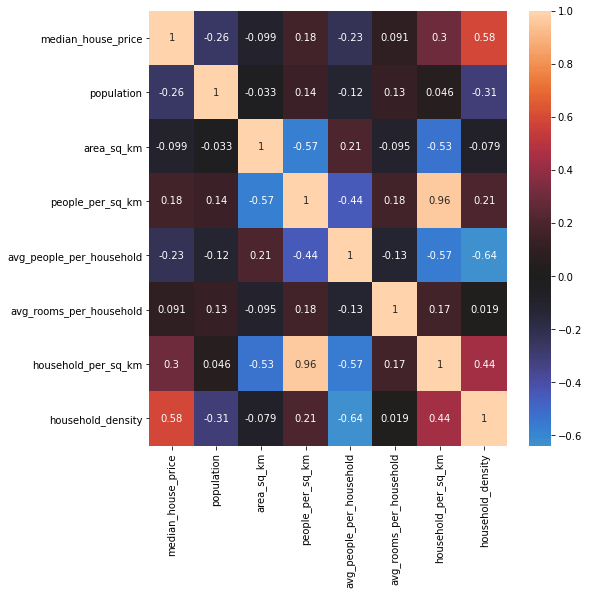

In [261]:
correlations_heatmap(housing)

Avg_rooms per household seems to be not correlated very strongly with any other indicator. remove ? what about area_sq_km ? remove also probably. check p-values ?

Before we can compute the weights, we should normalize the data.

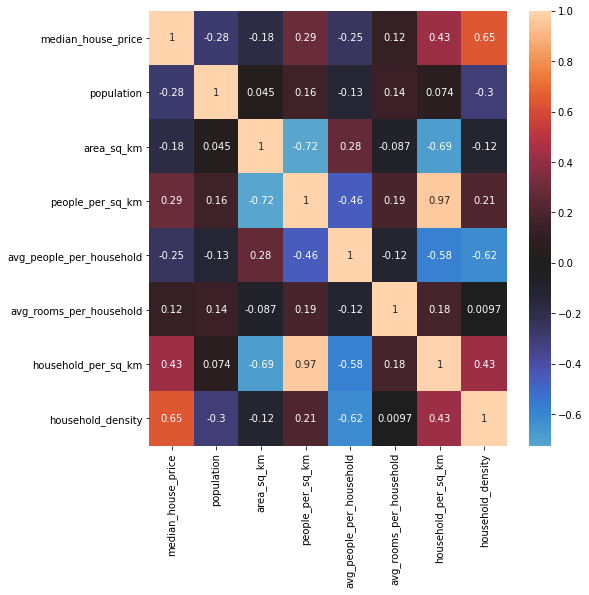

In [272]:
housing_norm = normalize(housing, 're_scale',remove_outliers = [True]) #changes correlations when removing outliers, same otherwise
correlations_heatmap(housing_norm)

In [302]:
housing_weights = calculate_weights(housing_norm)
housing_index = calculate_index_for_df(housing_norm,housing_weights )
print(housing_weights)
housing_index

Component cumulative variance: 42.199751904255166 %
Component cumulative variance: 62.60462931077025 %
Component cumulative variance: 75.9672838106831 %
Component cumulative variance: 88.08847675109088 %
Component cumulative variance: 95.06654573233976 %
                           weights
median_house_price        0.277780
population                0.139499
area_sq_km                0.015819
people_per_sq_km          0.237864
avg_people_per_household  0.123268
avg_rooms_per_household   0.019759
household_per_sq_km       0.262626
household_density         0.087455


,area_id,Names,index
0,E05000026,Abbey,0.412942
1,E05000027,Alibon,0.280549
2,E05000028,Becontree,0.357010
3,E05000029,Chadwell Heath,0.169956
4,E05000030,Eastbrook,0.194379
...,...,...,...
478,E05000645,Tachbrook,0.791610
479,E05000646,Vincent Square,0.857856
480,E05000647,Warwick,0.827668
481,E05000648,Westbourne,0.727057


Income, life satisaction, civic and work-life balance are all categories were we only have one sub-indicator, so no need to do any pca analysis, we must normalize them however, as well as the rest of the categories.

In [288]:
income_norm = normalize(income, 're_scale') 
life_satisfaction_norm = normalize(life_satisfaction, 're_scale') 
civic_norm = normalize(civic, 're_scale') 
work_life_balance_norm = normalize(work_life_balance, 're_scale') 
community_norm = normalize(community, 're_scale') 
education_norm = normalize(education, 're_scale') 
environment_norm = normalize(environment, 're_scale')  
health_norm = normalize(health, 're_scale') 
safety_norm = normalize(safety, 're_scale') 

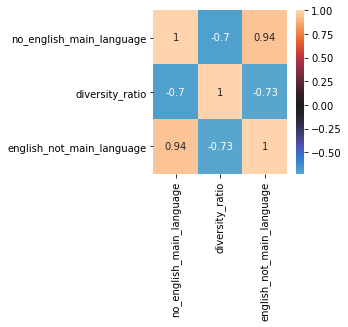

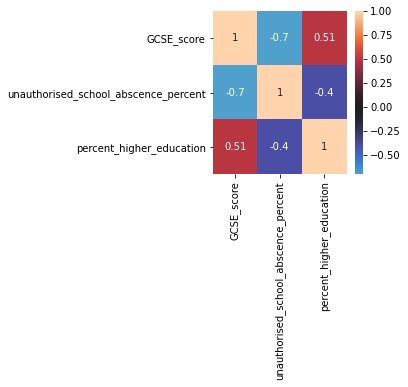

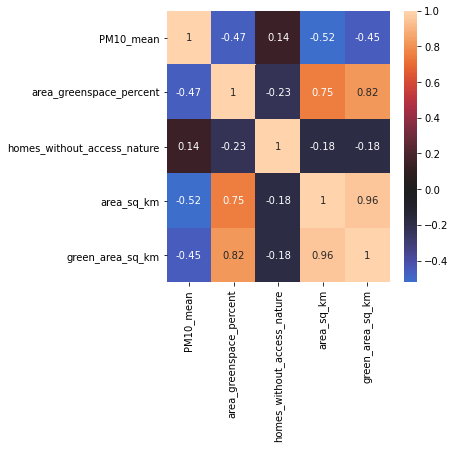

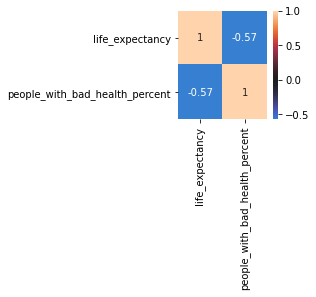

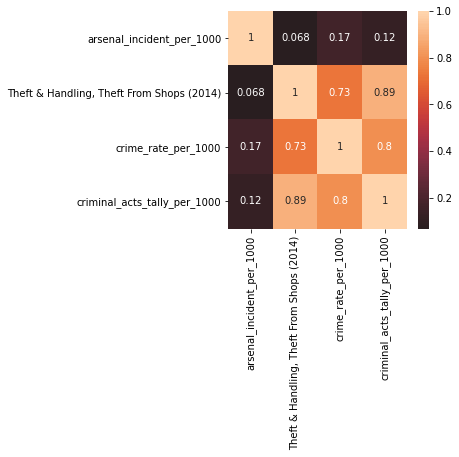

In [289]:
correlations_heatmap(community_norm)
correlations_heatmap(education_norm)
correlations_heatmap(environment_norm)
correlations_heatmap(health_norm)
correlations_heatmap(safety_norm)

In [306]:
safety_weights = calculate_weights(safety_norm)
safety_index = calculate_index_for_df(safety_norm, safety_weights)
safety_weights

Component cumulative variance: 63.34982792337489 %
Component cumulative variance: 91.27872586642548 %


,weights
arsenal_incident_per_1000,1.329063
"Theft & Handling, Theft From Shops (2014)",0.182748
crime_rate_per_1000,0.152568
criminal_acts_tally_per_1000,0.189336


In [297]:
data_frames = meta_data_indicators.values()

In [78]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['area_id'], how='outer'), list(data_frames))

In [89]:
df_merged.isnull().sum()

area_id                                      0
Names                                        0
median_house_price                           0
population                                   0
area_sq_km_x                                 0
people_per_sq_km                             0
avg_people_per_household                     0
avg_rooms_per_household                      0
household_per_sq_km                          0
household_density                            0
median_income                                0
employment_rate_16-64                        0
one_year_change_unemployment_claim           0
two_year_change_unemployment_claim           0
no_english_main_language                     0
diversity_ratio                              0
english_not_main_language                    0
GCSE_score                                   0
unauthorised_school_abscence_percent         0
percent_higher_education                     0
PM10_mean                                    0
area_greenspa

In [82]:
df_merged = df_merged.fillna(df_merged.mean())

In [166]:
X = df_merged.loc[:, df_merged.columns != 'area_id']
X = X.loc[:, X.columns != 'Names']


NameError: name 'df_merged' is not defined

In [ ]:
def pca(df) :
    
    X = df.loc[:, df.columns != 'area_id']
    
    if 'Names' in X.columns:
        X = X.loc[:, X.columns != 'Names']
    
    p = PCA()
    X_transformed = p.fit_transform(X)

    eigenvalues = p.explained_variance_

    print("Component 1 Values: {}".format(p.components_[0]))
    i = 0
    sum_variance = sum(eigenvalues)
    cum_variance = 0
    for eigenvalue in eigenvalues:    
        i+=1
        cum_variance += eigenvalue
        print("Component {} : {} - Cumulative Variance: {} %".format(i, eigenvalue, 100*cum_variance/sum_variance))